/var/folders/24/qfvzn2g12dgfpqrgc4zbxw500000gn/T/ipykernel_57335/3359237118.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/24/qfvzn2g12dgfpqrgc4zbxw500000gn/T/ipykernel_57335/3359237118.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/24/qfvzn2g12dgfpqrgc4zbxw500000gn/T/ipykernel_57335/3359237118.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


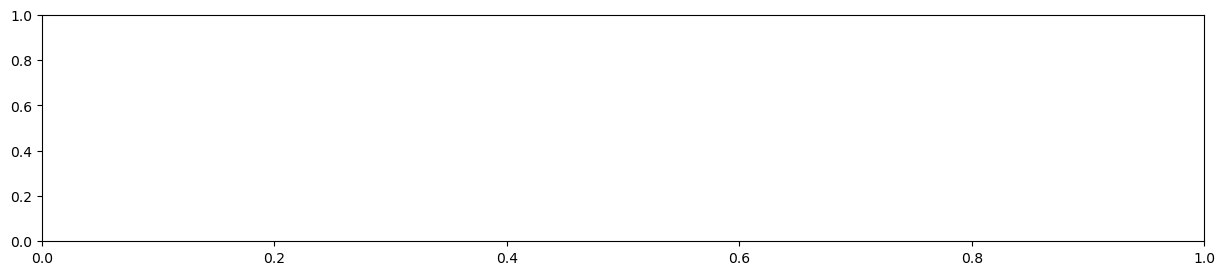

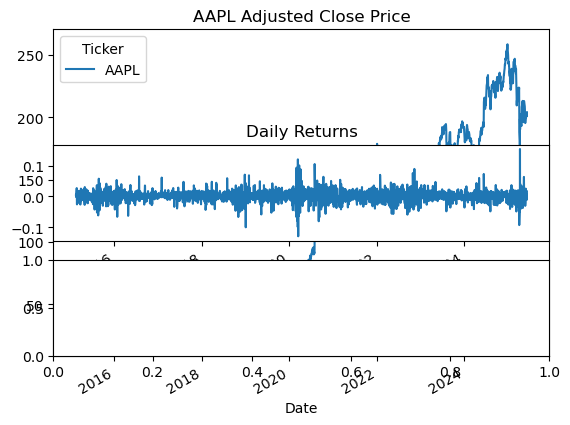

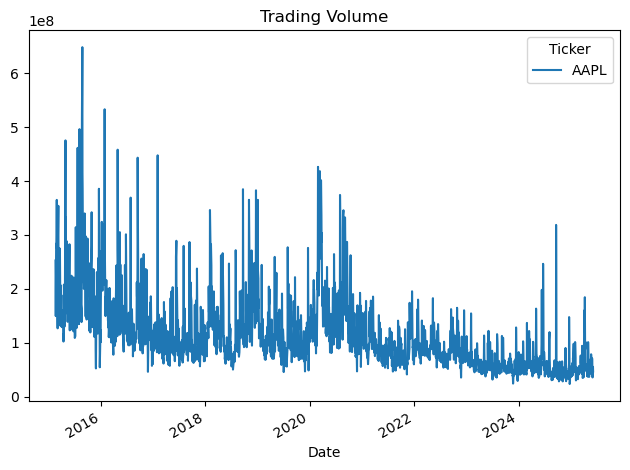

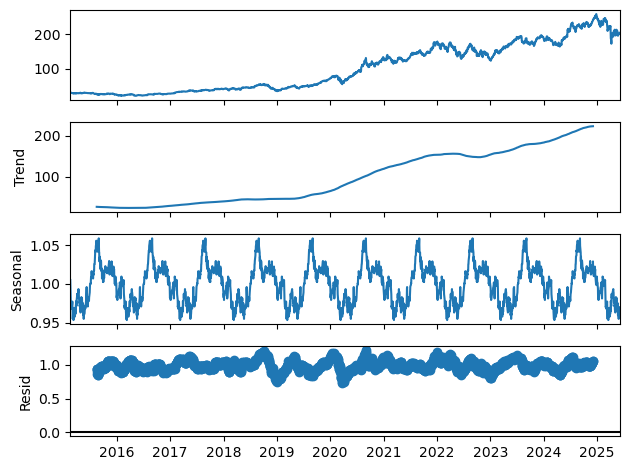

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Fetch updated stock data
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Preprocess data
def preprocess_data(df):
    # Handle missing values
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    
    # Feature engineering
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Return'].rolling(window=30).std()
    
    # Create target variable
    df['Target'] = df['Close'].shift(-1)
    
    return df.dropna()

# Parameters
ticker = 'AAPL'  # Apple stock
start_date = '2015-01-01'
end_date = '2025-06-10'

# Main workflow
df = get_stock_data(ticker, start_date, end_date)
processed_df = preprocess_data(df)

# Save cleaned data
processed_df.to_csv(f'{ticker}_cleaned_data.csv')

# Exploratory Visualization
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
processed_df['Close'].plot(title=f'{ticker} Adjusted Close Price')
plt.subplot(3,1,2)
processed_df['Daily_Return'].plot(title='Daily Returns')
plt.subplot(3,1,3)
processed_df['Volume'].plot(title='Trading Volume')
plt.tight_layout()
plt.savefig('exploratory_analysis.png')
plt.show()

# Seasonal decomposition
decomposition = seasonal_decompose(processed_df['Close'], 
                                  model='multiplicative', 
                                  period=252)  # 252 trading days/year
decomposition.plot()
plt.savefig('seasonal_decomposition.png')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8265.345, Time=2.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8263.304, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8261.023, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8260.572, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8264.449, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=8258.883, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=8260.588, Time=0.29 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=8262.287, Time=1.20 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=8258.235, Time=0.28 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=8259.924, Time=0.90 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=8259.905, Time=1.10 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=8261.556, Time=1.95 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=8259.323, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=8259.887, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pre

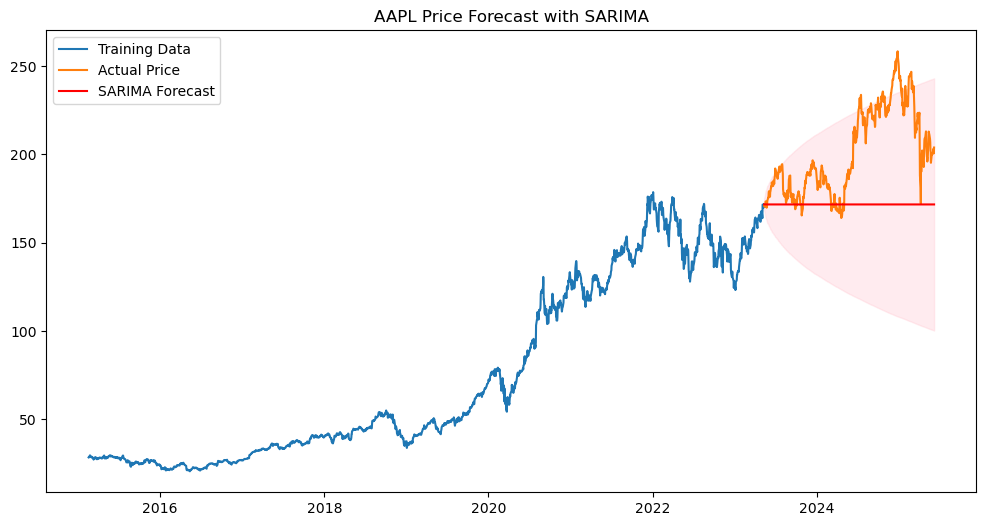

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare data
train_size = int(len(processed_df) * 0.8)
train = processed_df['Close'][:train_size]
test = processed_df['Close'][train_size:]

# Automated ARIMA parameter selection
auto_model = auto_arima(train, seasonal=True, m=12,
                        suppress_warnings=True,
                        stepwise=True, trace=True)
print(auto_model.summary())

# Best parameters from auto-arima
order = auto_model.order
seasonal_order = auto_model.seasonal_order

# Fit SARIMA model
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
results_sarima = model_sarima.fit(disp=False)

# Forecast
sarima_forecast = results_sarima.get_forecast(steps=len(test))
forecast_values = sarima_forecast.predicted_mean
confidence_intervals = sarima_forecast.conf_int()

# Evaluate
mse = mean_squared_error(test, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast_values)

print(f'SARIMA Performance:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}')

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Price')
plt.plot(test.index, forecast_values, label='SARIMA Forecast', color='red')
plt.fill_between(test.index, 
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title(f'{ticker} Price Forecast with SARIMA')
plt.legend()
plt.savefig('sarima_forecast.png')
plt.show()

22:11:14 - cmdstanpy - INFO - Chain [1] start processing
22:11:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet Performance:
RMSE: 57.46
MAE: 51.63


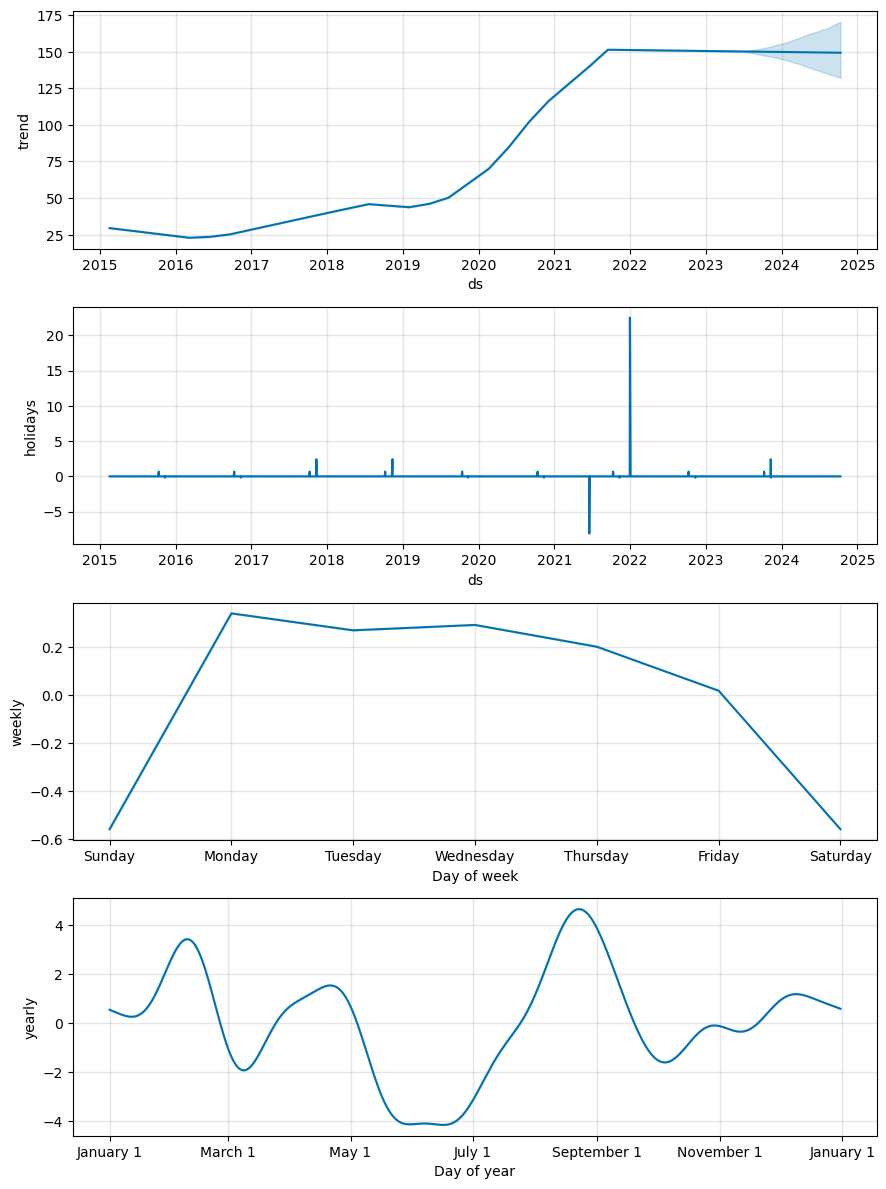

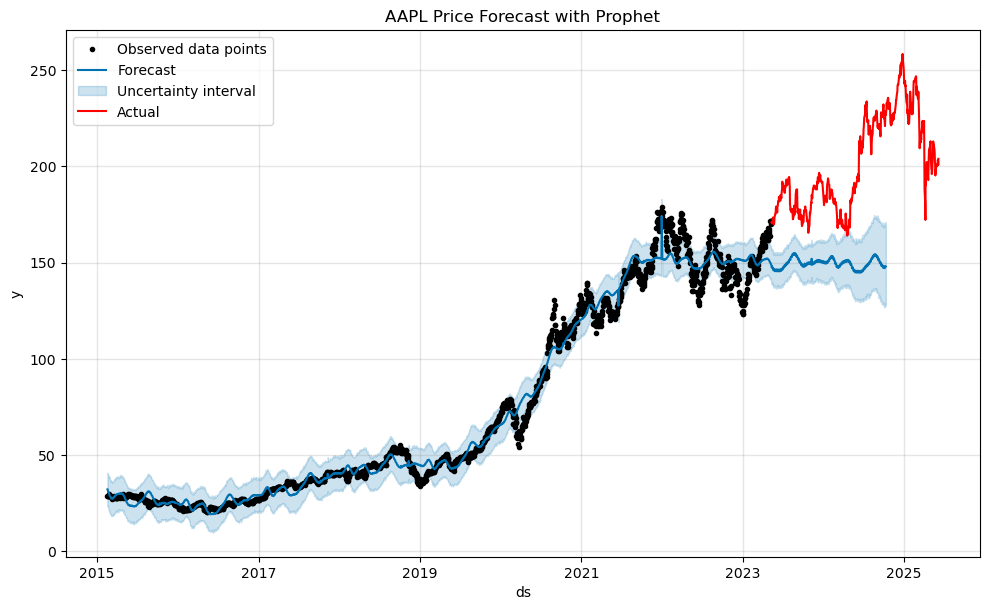

In [3]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = processed_df.reset_index()[['Date', 'Close']]
prophet_df.columns = ['ds', 'y']
prophet_train = prophet_df.iloc[:train_size]
prophet_test = prophet_df.iloc[train_size:]

# Create and fit model
model_prophet = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05
)
model_prophet.add_country_holidays(country_name='US')
model_prophet.fit(prophet_train)

# Create future dataframe
future = model_prophet.make_future_dataframe(periods=len(prophet_test))
forecast = model_prophet.predict(future)

# Extract test forecast
prophet_forecast = forecast.iloc[train_size:][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Evaluate
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast['yhat']))
prophet_mae = mean_absolute_error(prophet_test['y'], prophet_forecast['yhat'])

print(f'Prophet Performance:\nRMSE: {prophet_rmse:.2f}\nMAE: {prophet_mae:.2f}')

# Plot components
fig_components = model_prophet.plot_components(forecast)
plt.savefig('prophet_components.png')

# Plot forecast
fig_forecast = model_prophet.plot(forecast)
plt.plot(prophet_test['ds'], prophet_test['y'], color='r', label='Actual')
plt.title(f'{ticker} Price Forecast with Prophet')
plt.legend()
plt.savefig('prophet_forecast.png')
plt.show()

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0211 - val_loss: 6.1650e-04
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 5.5173e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 7.6665e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 6.3134e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.6248e-04 - val_loss: 5.1953e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.1511e-04 - val_loss: 6.9803e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.1986e-04 - val_loss: 5.9201e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.9869e-04 - val_loss: 5.2992e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.1558e-04 - val_loss: 0.0012
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.8171e-04 - val_loss: 8.9787e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.0879e-04 - val_loss: 4.5763e-04
Epoch 

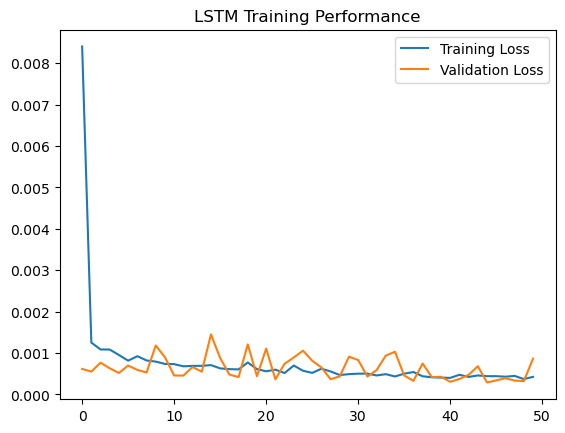

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Performance:
RMSE: 12.31
MAE: 10.90


ValueError: x and y must have same first dimension, but have shapes (2014,) and (2074,)

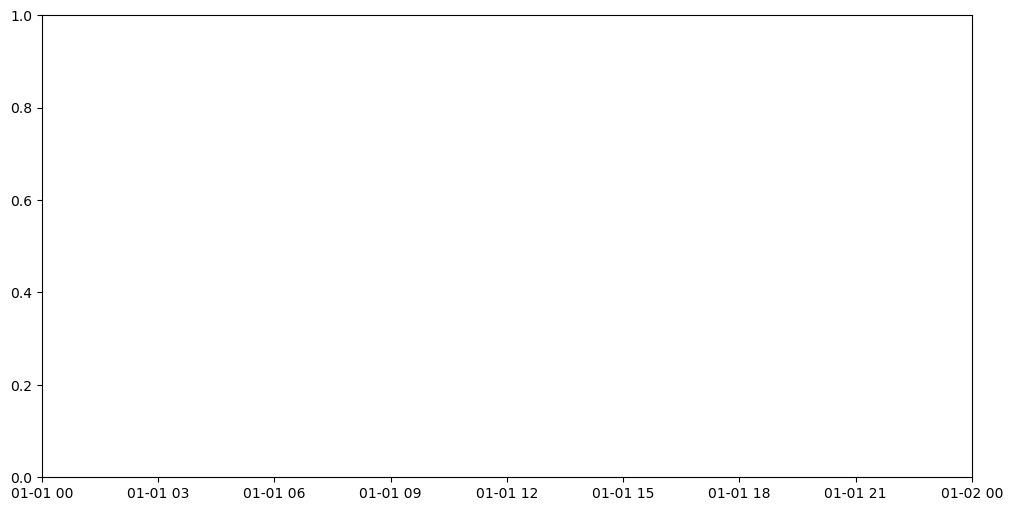

In [14]:
# Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(processed_df[['Close']])

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train-test split
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Performance')
plt.legend()
plt.savefig('lstm_training.png')
plt.show()

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Evaluate
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict[:,0]))
lstm_mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])

print(f'LSTM Performance:\nRMSE: {lstm_rmse:.2f}\nMAE: {lstm_mae:.2f}')

# Plot predictions
plt.figure(figsize=(12,6))
plt.plot(processed_df.index[SEQ_LENGTH:train_size], y_train_actual[0], label='Train Actual')
plt.plot(processed_df.index[train_size+SEQ_LENGTH:], y_test_actual[0], label='Test Actual')
plt.plot(processed_df.index[train_size+SEQ_LENGTH:], test_predict, label='LSTM Forecast')
plt.title(f'{ticker} Price Forecast with LSTM')
plt.legend()
plt.savefig('lstm_forecast.png')
plt.show()

Train dates: 2074, y_train: 2074
Test dates: 459, y_test: 459


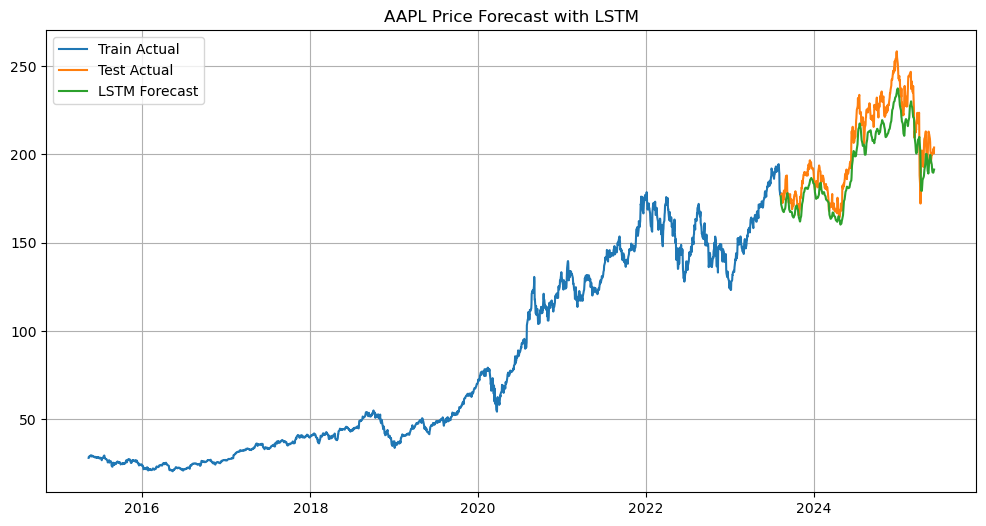

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ... [previous code until after predictions] ...

# Get the correct indices for plotting
total_sequences = len(X)  # Total number of sequences
train_sequences = len(X_train)  # Number of training sequences
test_sequences = len(X_test)   # Number of test sequences

# Get the dates corresponding to our sequences (skip first SEQ_LENGTH days)
plot_dates = processed_df.index[SEQ_LENGTH:SEQ_LENGTH + total_sequences]

# Split dates for train and test
train_dates = plot_dates[:train_sequences]
test_dates = plot_dates[train_sequences:]

# Verify shapes match
print(f"Train dates: {len(train_dates)}, y_train: {len(y_train_actual[0])}")
print(f"Test dates: {len(test_dates)}, y_test: {len(y_test_actual[0])}")

# Plot predictions with correct dates
plt.figure(figsize=(12,6))
plt.plot(train_dates, y_train_actual[0], label='Train Actual')
plt.plot(test_dates, y_test_actual[0], label='Test Actual')
plt.plot(test_dates, test_predict, label='LSTM Forecast')
plt.title(f'{ticker} Price Forecast with LSTM')
plt.legend()
plt.grid(True)
plt.savefig('lstm_forecast_corrected.png')
plt.show()

Model Comparison:
     Model       RMSE        MAE
0   SARIMA  38.272485  30.035849
1  Prophet  57.455778  51.627485
2     LSTM  12.305720  10.898330


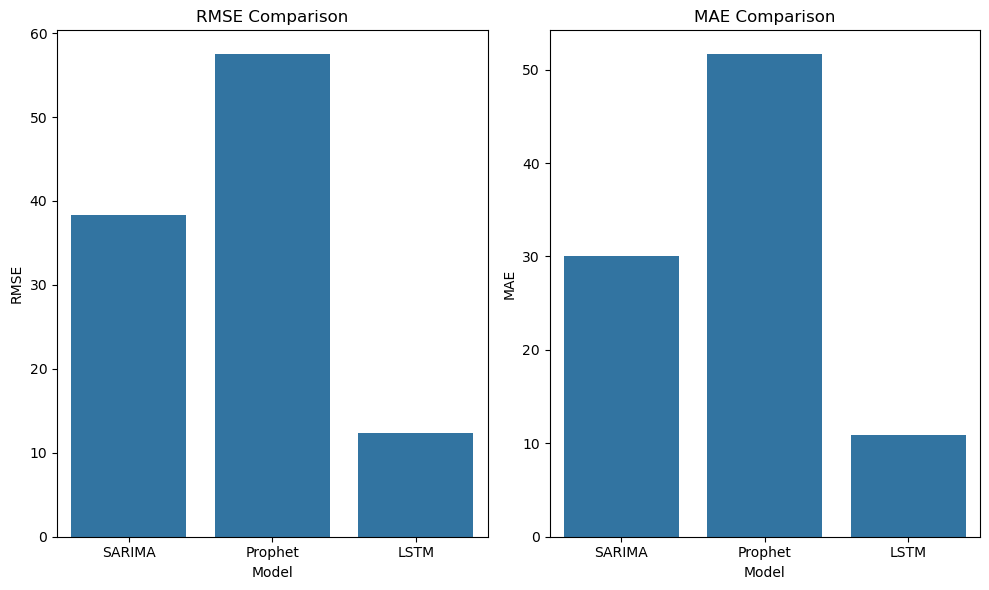

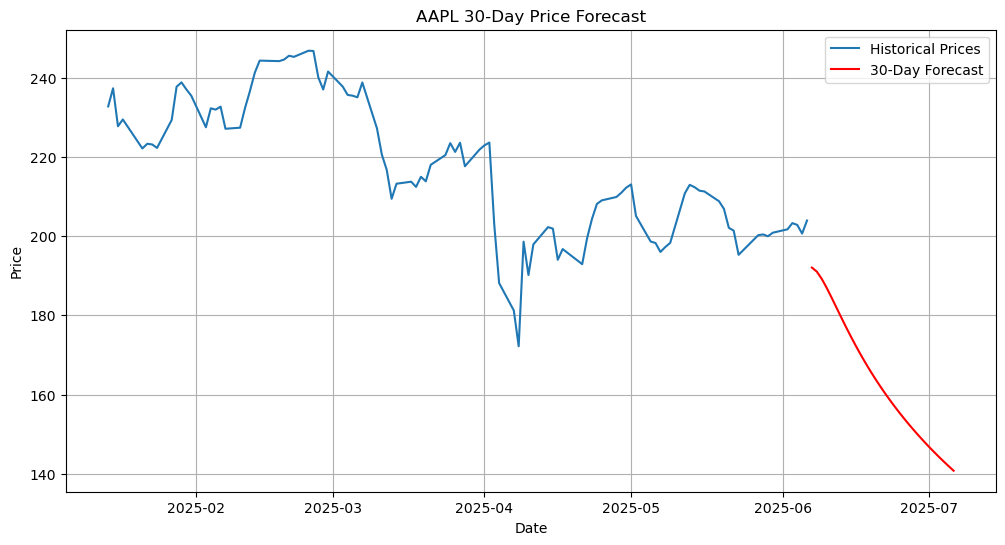

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume these exist from your earlier code:
# - model: trained LSTM model
# - scaled_data: normalized data used for LSTM
# - SEQ_LENGTH: sequence length used for LSTM (e.g., 60)
# - scaler: the MinMaxScaler used for scaling
# - processed_df: original DataFrame with datetime index and 'Close' prices
# - ticker: stock ticker string
# - rmse, prophet_rmse, lstm_rmse, mae, prophet_mae, lstm_mae: performance metrics

# ==============================
# Model Comparison Visualization
# ==============================

results = pd.DataFrame({
    'Model': ['SARIMA', 'Prophet', 'LSTM'],
    'RMSE': [rmse, prophet_rmse, lstm_rmse],
    'MAE': [mae, prophet_mae, lstm_mae]
})

print("Model Comparison:")
print(results)

# Plot comparison
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('RMSE Comparison')

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='MAE', data=results)
plt.title('MAE Comparison')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# ==============================
# Forecasting with LSTM
# ==============================

def forecast_future(model, last_sequence, days=30):
    future_forecast = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        # Ensure input shape is (1, SEQ_LENGTH, 1)
        input_sequence = np.expand_dims(current_sequence, axis=0)

        # Predict next value
        next_pred = model.predict(input_sequence, verbose=0)

        # Extract the scalar prediction
        next_value = next_pred[0, 0]
        future_forecast.append(next_value)

        # Update sequence (drop first, append new)
        current_sequence = np.append(current_sequence[1:], [[next_value]], axis=0)

    # Inverse scale predictions to original price range
    return scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Prepare input sequence
last_sequence = scaled_data[-SEQ_LENGTH:]

# Generate forecast
future_prices = forecast_future(model, last_sequence, days=30)

# ==============================
# Future Dates and Plotting
# ==============================

# Create future dates starting after last date
last_date = processed_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(processed_df.index[-100:], processed_df['Close'][-100:], label='Historical Prices')
plt.plot(future_dates, future_prices, label='30-Day Forecast', color='red')
plt.title(f'{ticker} 30-Day Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('30_day_forecast.png')
plt.show()


2025-06-11 22:29:52.184 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-06-11 22:29:52.204 No runtime found, using MemoryCacheStorageManager
2025-06-11 22:29:52.205 No runtime found, using MemoryCacheStorageManager
/var/folders/24/qfvzn2g12dgfpqrgc4zbxw500000gn/T/ipykernel_57335/15115044.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


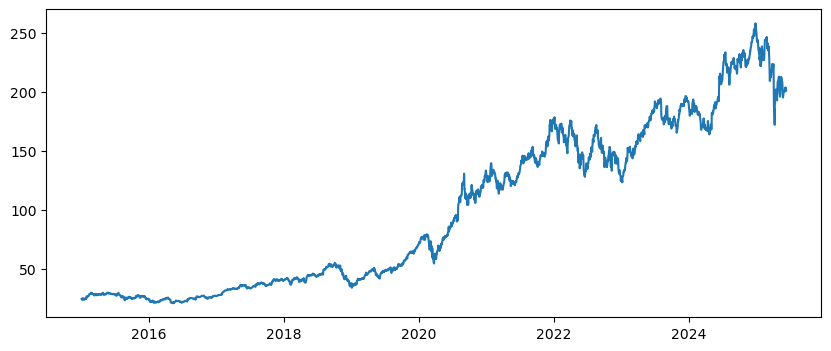

In [20]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

st.title('Stock Market Forecasting Dashboard')
st.sidebar.header('User Input')

# User inputs
ticker = st.sidebar.text_input('Stock Ticker', 'AAPL')
start_date = st.sidebar.date_input('Start Date', pd.to_datetime('2015-01-01'))
end_date = st.sidebar.date_input('End Date', pd.to_datetime('2025-06-10'))
forecast_days = st.sidebar.slider('Forecast Days', 7, 90, 30)

@st.cache_data
def load_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    return data

data = load_data(ticker, start_date, end_date)

# Display raw data
if st.checkbox('Show Raw Data'):
    st.subheader('Raw Data')
    st.write(data)

# Price chart
st.subheader(f'{ticker} Price Chart')
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(data['Close'])
st.pyplot(fig)

# Model selection
model_type = st.selectbox('Select Model', ['SARIMA', 'Prophet', 'LSTM'])

if st.button('Run Forecast'):
    st.subheader(f'{forecast_days}-Day Forecast using {model_type}')
    
    # Placeholder for actual model integration
    # In practice, you would load your pre-trained model here
    # and generate forecasts
    
    # Simulated forecast
    last_price = data['Close'][-1]
    forecast = pd.Series(
        [last_price * (1 + np.random.uniform(-0.02, 0.03)) for _ in range(forecast_days)],
        index=pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
    )
    
    # Plot forecast
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(data.index[-100:], data['Close'][-100:], label='Historical')
    ax.plot(forecast.index, forecast, label='Forecast', color='red')
    ax.fill_between(forecast.index, 
                    forecast * 0.95, 
                    forecast * 1.05, 
                    color='pink', alpha=0.3)
    ax.legend()
    st.pyplot(fig)
    
    # Display forecast values
    st.write('Forecasted Prices:')
    st.write(forecast.to_frame(name='Predicted Price'))